## 🔎 Exploratory analysis of the [Fake-News-Detection-dataset](https://huggingface.co/datasets/Pulk17/Fake-News-Detection-dataset)

In [2]:
import pandas as pd
import os

# Local file path = local_datasets\train.tsv
file_path = os.path.join("..", "local_datasets", "train.tsv")

df = pd.read_csv(file_path, sep="\t")

### 🧾 Information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   title       30000 non-null  object
 2   text        30000 non-null  object
 3   subject     30000 non-null  object
 4   date        30000 non-null  object
 5   label       30000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


First 5 rows of the dataset

In [4]:
df.head(5)

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


Last 5 rows of the dataset

In [5]:
df.tail(5)

,Unnamed: 0,title,text,subject,date,label
29995,6880,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politicsNews,"December 6, 2016",1
29996,17818,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,"October 11, 2017",1
29997,5689,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,"June 28, 2016",0
29998,15805,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,"November 2, 2017",1
29999,8143,"U.S., Israel sign $38 billion military aid pac...",The United States will give Israel $38 billion...,politicsNews,"September 14, 2016",1


### 🧾 Types of data

In [6]:
df.dtypes

Unnamed: 0     int64
title         object
text          object
subject       object
date          object
label          int64
dtype: object

### 🧾 Size of the dataset (rows and columns)

In [7]:
print("Size:", df.shape)

Size: (30000, 6)


### 📃 Columns description in the dataset

In [8]:
descriptions = [
    "The unique identifier for each news article.",
    "The title of the news article.",
    "The content of the news article.",
    "The subject indicates the category of the news article.",
    "The publication date of the news article.",
    "The label indicating whether the news article is real (1) or fake (0)."
]
    
df_description = pd.DataFrame({
    "Column name": df.columns,
    "Description": descriptions
})

df_description.index = df_description.index + 1  # Start index at 1

df_description.style.set_table_styles([
    {'selector': 'th',
     'props': [('text-align', 'left')]},
    {'selector': 'td',
     'props': [('text-align', 'left')]}
])

,Column name,Description
1,Unnamed: 0,The unique identifier for each news article.
2,title,The title of the news article.
3,text,The content of the news article.
4,subject,The subject indicates the category of the news article.
5,date,The publication date of the news article.
6,label,The label indicating whether the news article is real (1) or fake (0).


For an easier readability, we will rename some columns which are not easily readable. 
- For example, the column ```Unnamed: 0``` will be renamed to ```id```.
- The column ```label``` will be renamed to ```is_fake_news```.
- Values in the column ```is_fake_news``` will be renamed from 0 and 1 to ```True``` and ```False``` respectively.

In [9]:
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.rename(columns={"label": "is_fake_news"})
df["is_fake_news"] = df["is_fake_news"].map({0: True, 1: False})
df.head(5)

,id,title,text,subject,date,is_fake_news
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",False
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",True
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",False
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",True
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",True


### 🧾 Deletion of duplicate rows

The datasets contains duplicated entries. We will remove them to avoid bias in the training and evaluation of the models.
We need to consider that the column ```id``` is unique for each row, so we will not consider it when looking for duplicates.

In [10]:
duplicate_row_df = df[df.duplicated(subset=df.columns.difference(['id']))]
print("Number of duplicate rows:", duplicate_row_df.shape[0])
print("Size before removing duplicates:", df.shape)

Number of duplicate rows: 92
Size before removing duplicates: (30000, 6)


The dataset contains 92 duplicate rows. We will remove them now.

In [11]:
df = df.drop_duplicates(subset=df.columns.difference(['id']))
print("Size after removing duplicates:", df.shape)

Size after removing duplicates: (29908, 6)


### 🧾 Check for missing values in the dataset

Let's check if there are any missing values in the dataset.

In [12]:
print(df.isnull().sum())

id              0
title           0
text            0
subject         0
date            0
is_fake_news    0
dtype: int64


No missing values were found in the dataset.

### 🧾 Deletion of unnecessary news articles

Inside the dataset, there are almost 30k articles. 
However, we want to keep articles with a text length larger or equal than the average length of all articles. This is to avoid giving the chatbots articles that are too obvious to be classified as true or fake news.

In [13]:
df_average_length = df['text'].str.len().mean()
print("The average length of articles is:", df_average_length.astype(int)) # type: ignore

The average length of articles is: 2484


We proceed to remove every article with a text length smaller than the average length of all articles, so ```2484```.

In [14]:
df = df[df['text'].str.len() >= df_average_length] # type: ignore
print("Size after removing short articles:", df.shape)

Size after removing short articles: (12001, 6)


### 🧾 Deletion of obvious fake articles
Some articles, due only by their title, shows obvious signs of being fake news. Examples of this are titles with all capital letters, titles with many exclamation marks, titles with words like "VIDEO", "WATCH", "YOU WON'T BELIEVE", etc.
We will remove these articles from the dataset to avoid bias in the training and evaluation of the models.

Here some examples of obvious fake news titles found in the dataset

In [15]:
# Get articles containing uppercase words
uppercase_titles_df = df[df['title'].str.contains(r'\b[A-Z]{2,}\b', na=False)]
uppercase_titles_df.head(10)

,id,title,text,subject,date,is_fake_news
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",False
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",True
21,20770,SHAMEFUL! AIR FORCE VETERAN Ousted From Collea...,OBAMA S AMERICA: Why do you think people are ...,left-news,"Apr 6, 2016",True
41,4159,T-shirts Were Sold Outside Bills Game With Rif...,San Francisco 49ers quarterback Colin Kaeperni...,News,"October 17, 2016",True
46,11158,COLLEGE SNOWFLAKES FREAK OUT! “Feel Unsafe” Ov...,Notre Dame students are freaking out over Vice...,politics,"Apr 12, 2017",True
50,8626,Donna Brazile DESTROYS Palin For Blaming Her W...,Sarah Palin did something entirely expected of...,News,"January 21, 2016",True
63,3060,George Takei Just F*cking HUMILIATED Trump Ove...,"In case you have not heard, an addendum to the...",News,"January 11, 2017",True
64,4034,U.S. FCC chief unveils plan to scrap Obama-era...,The head of the Federal Communications Commiss...,politicsNews,"April 27, 2017",False
65,1686,WATCH: Jake Tapper HUMILIATES Trump With The S...,Donald Trump recently said that grading his fi...,News,"April 25, 2017",True
71,17512,"EU plans Brexit summit gesture, May hints on cash",Britain will be offered a goodwill gesture at ...,worldnews,"October 13, 2017",False


As we can see, few titles are not fake news though, but they are detected as such due to the presence of uppercase words. Because of this, we will create an array of keywords to filter out these cases.

In [16]:
safe_keywords = ["NASA", "FBI", "CIA", "USA", "UN", "EU", "U.S", "FCC", "NBA", "NFL", "COVID"]
print("Dataset size before removing shouty titles:", df.shape)

Dataset size before removing shouty titles: (12001, 6)


Now we are ready to remove the obvious fake news articles from the dataset, excluding the articles which contain a safe keyword. We create a function to do this, the function is able to detect whether a function is shouted, so checks if the title contains more uppercase words than lowercase words or there are more than 2 uppercase words in the title.

In [17]:
import re
import unicodedata

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.replace("’", "'")
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

def is_shouty_title(title: str) -> bool:
    """Return True if the title looks shouty (many uppercase words)."""
    title = normalize_text(title)
    words = re.findall(r"[A-Za-z']+", title)
    uppercase_words = [w for w in words if w.isupper() and len(w) > 1]
    uppercase_filtered = [w for w in uppercase_words if w not in safe_keywords]
    total_words = len(words)
    ratio = len(uppercase_filtered) / total_words if total_words > 0 else 0
    return ratio > 0.3 or len(uppercase_filtered) >= 2 or title.isupper()

escaped_keywords = [re.escape(k) for k in safe_keywords]
pattern = r'\b(?:' + '|'.join(escaped_keywords) + r')\b'

Before prooceeding with the filtering, we show a graphical representation of the shouted vs non-shouted titles in the dataset.

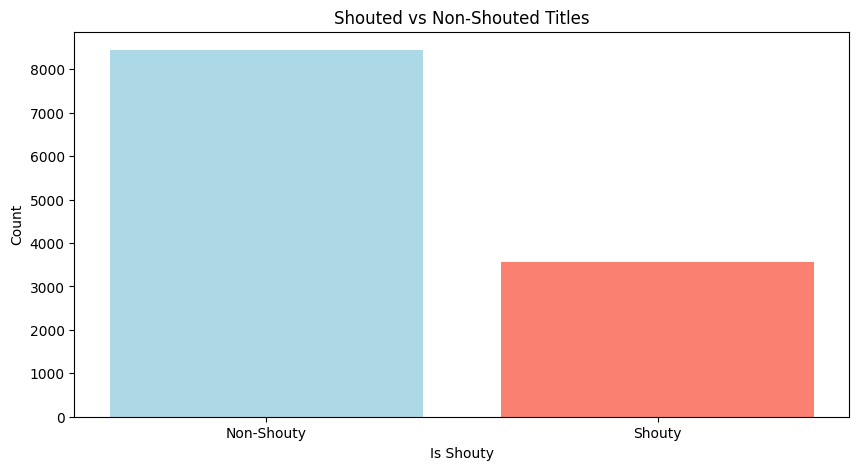

Number of real news articles: 5851 (48.75%)
Number of fake news articles: 6150 (51.25%)


In [18]:
# Before prooceeding with the filtering, we show a graphical representation of the shouted vs non-shouted titles in the dataset.
import matplotlib.pyplot as plt

df['is_shouty'] = df['title'].apply(is_shouty_title)

plt.figure(figsize=(10, 5))
plt.bar(df['is_shouty'].value_counts().index, df['is_shouty'].value_counts().values, color=['lightblue', 'salmon'])
plt.title('Shouted vs Non-Shouted Titles')
plt.xlabel('Is Shouty')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Shouty', 'Shouty'])
plt.show()

real_news_count = df['is_fake_news'].value_counts()[False]
fake_news_count = df['is_fake_news'].value_counts()[True]
real_news_percent = (real_news_count / (real_news_count + fake_news_count)) * 100
fake_news_percent = (fake_news_count / (real_news_count + fake_news_count)) * 100
print("Number of real news articles:", real_news_count, "({:.2f}%)".format(real_news_percent))
print("Number of fake news articles:", fake_news_count, "({:.2f}%)".format(fake_news_percent))

As we can see, there are not many shouted titles in the dataset, but to guarantee a proper evaluation of the models, we will remove them. The methodology will get randomly some articles from the dataset, so removing these shouted titles will avoid bias in the evaluation.

In [19]:
df['is_shouty'] = df['title'].apply(is_shouty_title)
df = df[~df['is_shouty']].copy()
df.drop(columns=['is_shouty'], inplace=True)

df.head(10)

,id,title,text,subject,date,is_fake_news
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",False
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",False
6,270,Country Guitarist Who Survived Vegas Shooting ...,"Caleb Keeter, a lifelong proponent of the Seco...",News,"October 2, 2017",True
12,14878,Obama And Kerry Exposed: Secret Side Deals Wit...,Bravo! These two great Americans make me have ...,politics,"Nov 27, 2015",True
13,1560,Ex-N.Y. state senate leader's corruption convi...,A U.S. appeals court on Tuesday threw out the ...,politicsNews,"September 26, 2017",False
15,15262,Trump's stop in Vietnam a poignant one for U.S...,Whether they like President Donald Trump or no...,worldnews,"November 9, 2017",False
16,6587,Trump 'arms race' comment sows more doubt on n...,U.S. President-elect Donald Trump sowed more d...,politicsNews,"December 22, 2016",False
22,20860,Hashtag politics: Merkel tries to get in with ...,"After 12 years in power, Chancellor Angela Mer...",worldnews,"September 6, 2017",False
23,5327,Progressive Champion Elizabeth Warren Will Del...,The Democratic Party is poised to have a conve...,News,"July 25, 2016",True
24,12539,Iran will treat jailed aid worker as Iranian c...,Iran will treat a British-Iranian aid worker a...,worldnews,"December 11, 2017",False


Let's count how many articles remain after this filtering.

In [20]:
df.shape

(8444, 6)

In this way, we have removed all the obvious fake news articles from the dataset. This assures a cleaner dataset for the training and evaluation of the models, in order to check whether they are able to detect fake news in a more subtle way.

### 🧾 Number of true vs fake news

We can check the number of true vs fake news in the dataset, in order to see if the dataset is balanced or not.

In [21]:
real_news_count = df['is_fake_news'].value_counts()[False]
fake_news_count = df['is_fake_news'].value_counts()[True]
real_news_percent = (real_news_count / (real_news_count + fake_news_count)) * 100
fake_news_percent = (fake_news_count / (real_news_count + fake_news_count)) * 100
print("Number of real news articles:", real_news_count, "({:.2f}%)".format(real_news_percent))
print("Number of fake news articles:", fake_news_count, "({:.2f}%)".format(fake_news_percent))


Number of real news articles: 5817 (68.89%)
Number of fake news articles: 2627 (31.11%)


Here a graphical representation of the number of true vs fake news articles, to show if the dataset is balanced or not.

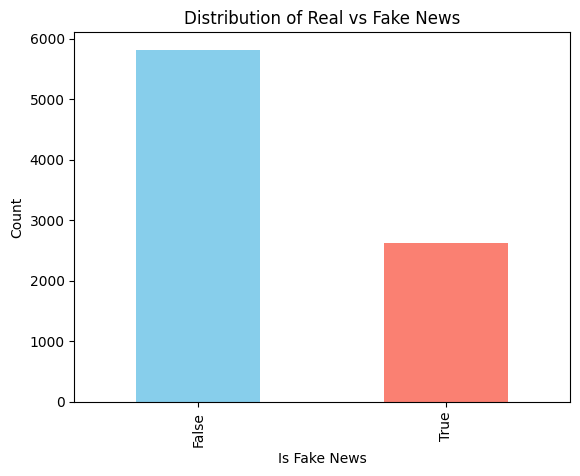

In [22]:
import matplotlib.pyplot as plt

df["is_fake_news"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Distribution of Real vs Fake News")
plt.xlabel("Is Fake News")
plt.ylabel("Count")
plt.show()

We can see that the dataset is not balanced, after the filtering, lot of fake news with obvious titles have been removed. In this moment, the dataset contains few fake news, which will be usefult to our purpose of training and evaluating the models to detect fake news in a more subtle way.

### 🧾 Subject of the articles
We can check the subject of the articles in the dataset, in order to see which topics cover the dataset.

Text(0.5, 1.0, 'Distribution of Article Subjects')

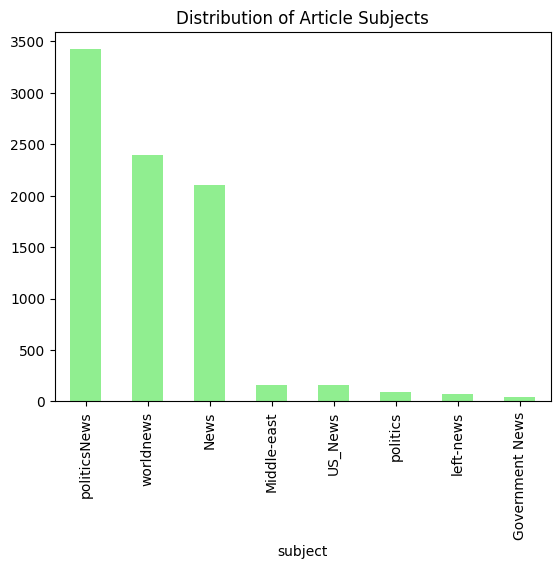

In [23]:
import matplotlib.pyplot as plt

df["subject"].value_counts().plot(kind="bar", color="lightgreen")
plt.title("Distribution of Article Subjects")

Most of the articles in the dataset are about politics. Other subjects are pretty low, as long as the filter removed every obvious fake news articles.

### 🧾 Conclusion and Main outcomes
In this notebook, we have explored the Fake-News-Detection-dataset. We have done following operations to clean the dataset:
- Removed duplicate rows
- Removed articles with a text length smaller than the average length of all articles
- Checked for missing values
- Removed obvious fake news articles based on their titles
- Analyzed the balance of true vs fake news articles
The dataset is now ready to be used for the evaluation of the chatbots 😊 .

In [24]:
import os
os.makedirs("csv_files", exist_ok=True)
df.to_pickle(os.path.join("csv_files", "clean_fake_news.pkl"))

The main outcomes of this exploratory analysis are:
- The filtered dataset contains fewer articles than the original one, but it is cleaner and more suitable for the evaluation of the models.
- The dataset is not balanced, with more true news articles than fake news articles.
- Now the fake news articles are more subtle and not easily detectable based on their titles.
- Most of the articles in the dataset are about politics.